
# Crypto ETL — Storytelling Notebook

This notebook walks through the project end-to-end:
- **ETL**: what we extract, how we transform (CSV + Parquet), and how we **load into PostgreSQL**.
- **SQL**: run readable queries to explore the schema and data.
- **Analysis**: compute per-coin metrics (avg, std, growth, volatility).
- **Visualization**: a couple of simple plots to tell the story.

> Tip: run this inside your project **virtual environment**.



## How to run (locally)

1. Activate your venv and ensure deps are installed:
   ```bash
   source venv/bin/activate
   pip install -r requirements.txt
   ```
2. Start Jupyter:
   ```bash
   jupyter lab   # or: jupyter notebook
   ```
3. Open `Crypto_ETL_Story.ipynb` and run cells top-to-bottom.


In [1]:

# Imports & display options
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", None)

# Matplotlib: single-figure plots; no explicit colors (keeps it simple/portable)
%matplotlib inline



## Database connection

Credentials are read from environment variables (recommended).  
Fallback: edit the variables below manually **only for local demos**.


In [2]:

DB_USER = os.getenv("PGUSER", "ricardo")
DB_PASS = os.getenv("PGPASSWORD", "crypto")  # <-- replace locally or set env var
DB_HOST = os.getenv("PGHOST", "localhost")
DB_PORT = os.getenv("PGPORT", "5432")
DB_NAME = os.getenv("PGDATABASE", "crypto")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Sanity check: open/close a connection
with engine.connect() as conn:
    version = conn.execute(text("SELECT version()")).scalar()
version


'PostgreSQL 12.22 (Ubuntu 12.22-0ubuntu0.20.04.4) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0, 64-bit'


## Inspect schema & row counts
Let's list tables and quick counts to set the stage.


In [3]:

with engine.connect() as conn:
    # Tables present
    tables = pd.read_sql("""
        SELECT table_schema, table_name
        FROM information_schema.tables
        WHERE table_schema='public'
        ORDER BY table_name
    """, conn)
tables


,table_schema,table_name
0,public,coins
1,public,market_history
2,public,market_snapshots


In [4]:

with engine.connect() as conn:
    counts = {}
    for t in ["coins", "market_snapshots", "market_history"]:
        counts[t] = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t}", conn).iloc[0,0]
pd.DataFrame.from_dict(counts, orient="index", columns=["rows"])


,rows
coins,5
market_snapshots,65
market_history,7974



## Latest snapshot

Show the most recent `snapshot_id` from `market_snapshots` and its rows.


In [5]:

with engine.connect() as conn:
    latest_sid = pd.read_sql("""
        SELECT MAX(snapshot_id) AS snapshot_id
        FROM market_snapshots
    """, conn).iloc[0,0]

latest_sid


'20251003T114913Z'

In [6]:

with engine.connect() as conn:
    latest_rows = pd.read_sql("""
        SELECT *
        FROM market_snapshots
        WHERE snapshot_id = %(sid)s
        ORDER BY rank NULLS LAST, coin_id
    """, conn, params={"sid": latest_sid})
latest_rows


,snapshot_id,coin_id,price_eur,market_cap,volume_24h,rank,last_updated
0,20251003T114913Z,bitcoin,102534.000000,2.043420e+12,6.105442e+10,1,2025-10-03T11:48:42.083Z
1,20251003T114913Z,ethereum,3820.070000,4.612728e+11,3.679318e+10,2,2025-10-03T11:48:43.877Z
2,20251003T114913Z,ripple,2.590000,1.550675e+11,6.147100e+09,3,2025-10-03T11:48:41.974Z
3,20251003T114913Z,tether,0.852128,1.501811e+11,1.129910e+11,4,2025-10-03T11:48:43.622Z
4,20251003T114913Z,binancecoin,941.620000,1.310095e+11,2.914270e+09,5,2025-10-03T11:48:41.752Z



## Time coverage per coin (market_history)
For each coin, show the min/max timestamp to understand the time range.


In [7]:

with engine.connect() as conn:
    coverage = pd.read_sql("""
        SELECT coin_id, MIN(ts) AS start_ts, MAX(ts) AS end_ts, COUNT(*) AS n_rows
        FROM market_history
        GROUP BY coin_id
        ORDER BY coin_id
    """, conn)
coverage


,coin_id,start_ts,end_ts,n_rows
0,binancecoin,2025-07-29 11:00:59.108,2025-10-03 11:50:14,1595
1,bitcoin,2025-07-29 11:04:47.755,2025-10-03 11:49:01,1595
2,ethereum,2025-07-29 11:04:58.434,2025-10-03 11:49:24,1595
3,ripple,2025-07-29 11:04:24.617,2025-10-03 11:49:42,1595
4,tether,2025-07-29 11:04:00.586,2025-10-03 11:49:53,1594



## Descriptive statistics per coin

Compute average price, variance, stddev, min/max, % growth, relative volatility.


In [8]:

with engine.connect() as conn:
    df = pd.read_sql("""
        SELECT coin_id, ts, price_eur
        FROM market_history
    """, conn)

# Grouped metrics
stats = df.groupby("coin_id")["price_eur"].agg(
    avg_price="mean",
    variance="var",
    stddev="std",
    min_price="min",
    max_price="max"
)

# Percentage growth
stats["pct_growth"] = (stats["max_price"] - stats["min_price"]) / stats["min_price"] * 100.0

# Relative volatility
stats["rel_volatility_pct"] = (stats["stddev"] / stats["avg_price"]) * 100.0

# Time range per coin
ranges = df.groupby("coin_id")["ts"].agg(start_date="min", end_date="max")

result = stats.join(ranges).reset_index().rename(columns={"index": "coin_id"})
result


,coin_id,avg_price,variance,stddev,min_price,max_price,pct_growth,rel_volatility_pct,start_date,end_date
0,binancecoin,756.373790,4.607837e+03,67.881051,635.859250,946.016360,48.777636,8.974538,2025-07-29 11:00:59.108,2025-10-03 11:50:14
1,bitcoin,97839.457620,8.237599e+06,2870.121794,91732.800000,105769.560000,15.301790,2.933501,2025-07-29 11:04:47.755,2025-10-03 11:49:01
2,ethereum,3657.764733,6.933799e+04,263.321073,2916.932000,4213.575000,44.452288,7.198961,2025-07-29 11:04:58.434,2025-10-03 11:49:24
3,ripple,2.551988,1.464835e-02,0.121030,2.315228,2.884300,24.579514,4.742592,2025-07-29 11:04:24.617,2025-10-03 11:49:42
4,tether,0.856131,3.092940e-05,0.005561,0.842653,0.876834,4.056376,0.649599,2025-07-29 11:04:00.586,2025-10-03 11:49:53



### (Optional) Save summary to `analysis/summary_stats.csv`


In [9]:

from pathlib import Path
out_dir = Path("analysis")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "summary_stats.csv"
result.to_csv(out_path, index=False)
out_path


PosixPath('analysis/summary_stats.csv')


## Plot — Normalized price evolution (100 = first point)

Simple normalization to compare trajectories across coins.


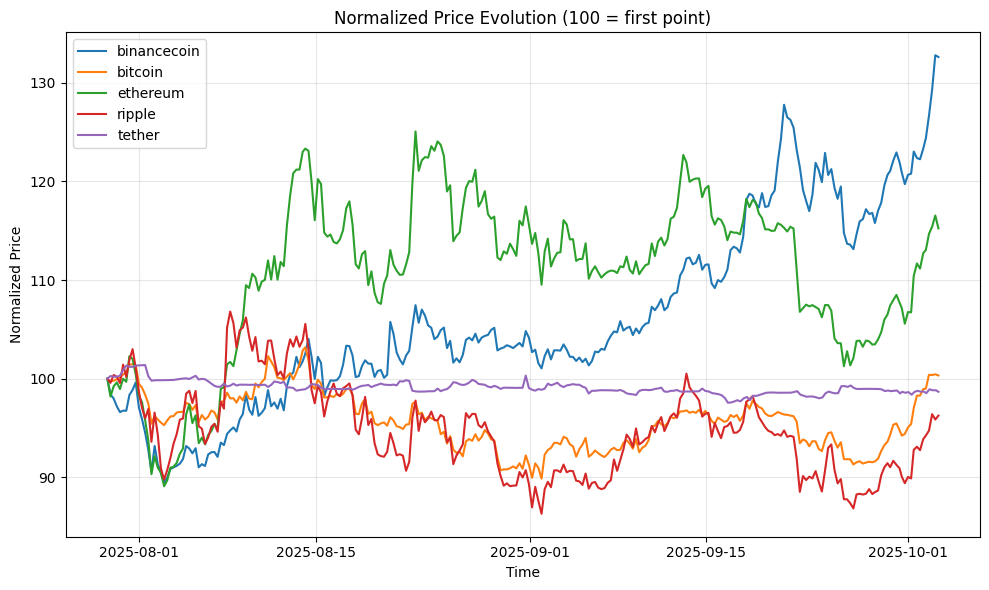

In [10]:

# Prepare time series (downsample a bit for readability)
df_plot = df.sort_values(["coin_id", "ts"]).copy()
fig = plt.figure(figsize=(10, 6))

for coin_id, grp in df_plot.groupby("coin_id"):
    g = grp.iloc[::6]  # sample every N points if very dense
    base = g["price_eur"].iloc[0]
    norm = g["price_eur"] / base * 100.0
    plt.plot(g["ts"], norm, label=coin_id)

plt.title("Normalized Price Evolution (100 = first point)")
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Plot — Sharpe Ratio per coin (daily returns, simple)

This is a lightweight proxy (no risk-free rate) just to compare signal-to-noise.


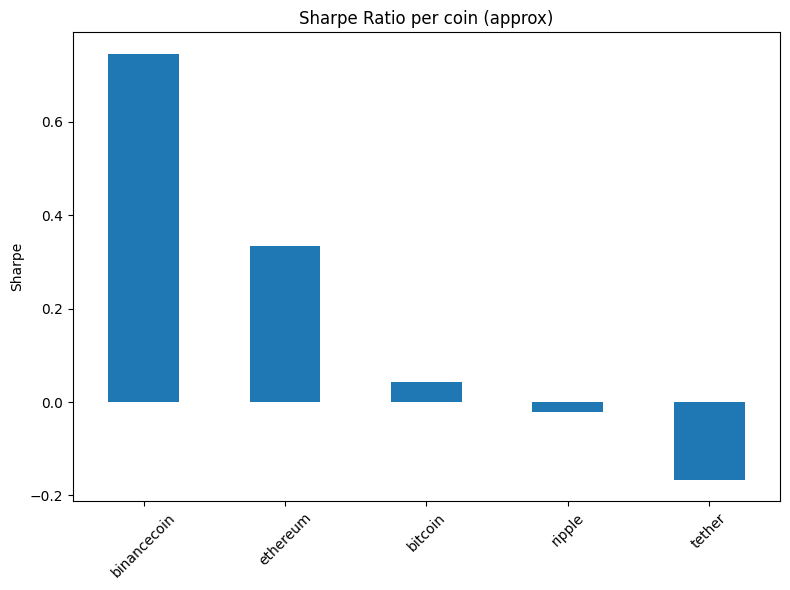

In [11]:

# Compute daily-ish returns (based on available frequency)
sr = {}
for coin_id, grp in df.sort_values(["coin_id", "ts"]).groupby("coin_id"):
    g = grp.copy()
    g["ret"] = g["price_eur"].pct_change()
    mean_ret = g["ret"].mean()
    std_ret = g["ret"].std()
    if std_ret and std_ret > 0:
        daily_sharpe = mean_ret / std_ret
        # crypto trades 365 days
        sr[coin_id] = daily_sharpe * (365 ** 0.5)
    else:
        sr[coin_id] = 0.0

sr_df = pd.DataFrame.from_dict(sr, orient="index", columns=["sharpe"]).sort_values("sharpe", ascending=False)
ax = sr_df["sharpe"].plot(kind="bar", rot=45, figsize=(8,6))
plt.title("Sharpe Ratio per coin (approx)")
plt.ylabel("Sharpe")
plt.tight_layout()
plt.show()



## Wrap-up

- We explored the **PostgreSQL** schema and counts.
- Queried **latest snapshot** and **time coverage**.
- Computed **summary metrics** and plotted a couple of simple visuals.


